<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [8]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, RidgeCV, Ridge, SGDRegressor, LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix,mean_absolute_error
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [12]:
# Load the data
house = pd.read_csv('./housing.csv')

In [13]:
house.info()# a lot of null values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# Data cleaning

In [14]:
# replace null value with 0
for item in ['LotFrontage', 'MasVnrArea']:
    house.loc[house[item].isnull(), item] = 0

In [15]:
#replace null value with NoAcc
house.loc[house['Alley'].isnull(), 'Alley'] = 'NoAcc'
# replace null value with None
house.loc[house['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [16]:
#replace Null value with NoBsmt since all related to basement
house[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = \
house[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='NoBsmt')


In [17]:
#replace null value with SBrkr
house.loc[house['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
#replace null value with NoFirepl
house.loc[house['FireplaceQu'].isnull(), 'FireplaceQu'] = 'NoFirepl'

In [18]:
#replace null value with NoGarage since all related to Garage
house[['GarageType','GarageFinish','GarageQual','GarageCond']] = \
house[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='NoGarage')

In [19]:
#replace null value with Yearbuilt, year cannot be 0
house.loc[house['GarageYrBlt'].isnull(), 'GarageYrBlt'] = house.loc[house['GarageYrBlt'].isnull(), 'YearBuilt']
house['GarageYrBlt'] = house['GarageYrBlt'].astype('int')

In [20]:

house.loc[house['PoolQC'].isnull(),'PoolQC'] = 'NoPool'
house.loc[house['Fence'].isnull(),'Fence'] = 'NoFence'
house.loc[house['MiscFeature'].isnull(),'MiscFeature'] = 'None'

In [21]:
#Selecting Fixed Features
fixed = house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','LotConfig',\
        'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd',\
        'Foundation','BsmtQual','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
        'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
        'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea', 'YrSold', 'SalePrice']]

In [22]:
# Seperating the object dtypes to convert to dummy variables
fixed_num = fixed.select_dtypes(include=np.number)
fixed_object = fixed.select_dtypes('O')

In [23]:
dummies = pd.get_dummies(fixed_object, drop_first= True)
fixed_features = fixed_num.merge(dummies, left_index = True, right_index = True,how = 'outer')


In [24]:
fixed_features.info()
# Total 110 predictor variables after converting to dummy variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 110 entries, MSSubClass to GarageType_NoGarage
dtypes: float64(1), int64(25), uint8(84)
memory usage: 416.4 KB


In [25]:
cols = list(fixed_features.columns)
cols.remove('SalePrice')

X = fixed_features[cols]
y = fixed.SalePrice


In [26]:
#Split train and test data
X_train= X[X['YrSold']<2010]
y_train= fixed_features.loc[fixed_features[fixed_features['YrSold']<2010].index, 'SalePrice']

X_test= X[X['YrSold']==2010]
y_test= fixed_features.loc[fixed_features[fixed_features['YrSold']==2010].index, 'SalePrice']

In [27]:
#Standardise the Predictor variables
ss =StandardScaler()

Xs_train =pd.DataFrame(ss.fit_transform(X_train), columns=X.columns)
Xs_test =pd.DataFrame(ss.fit_transform(X_test), columns=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
# Using LassoCV to find the best alpha
best_lasso = LassoCV(n_alphas=100, cv=10)
best_lasso.fit(Xs_train, y_train)
print(best_lasso.get_params)
print(best_lasso.alpha_)

<bound method BaseEstimator.get_params of LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)>
601.7827750460926


# Lasso Regression

In [31]:
lasso = Lasso(alpha = best_lasso.alpha_)

lasso.fit(Xs_train, y_train)

print("Lasso Regression score:", lasso.score(Xs_test, y_test))

Lasso Regression score: 0.8727244873221371


In [32]:
#Plotting the coefficents, ranking from the highest 
lasso_coefs = pd.DataFrame({'coef':lasso.coef_,
                            'mag':np.abs(lasso.coef_),
                            'variable':Xs_train.columns})

lasso_coefs.sort_values('mag', inplace=True, ascending=False)

lasso_coefs.head(10)

,coef,mag,variable
12,28819.377461,28819.377461,GrLivArea
100,-16665.520353,16665.520353,BsmtQual_Gd
102,-16295.365256,16295.365256,BsmtQual_TA
59,11644.542775,11644.542775,Neighborhood_NridgHt
22,9819.833488,9819.833488,GarageCars
58,9496.009440,9496.009440,Neighborhood_NoRidge
3,8049.145414,8049.145414,YearBuilt
4,7736.586278,7736.586278,YearRemodAdd
65,7371.864911,7371.864911,Neighborhood_StoneBr
8,5785.420501,5785.420501,TotalBsmtSF


In [33]:
lasso_features = lasso_coefs.loc[lasso_coefs.mag != 0].info()
# 38 variables have been removed after lasso regression

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 12 to 80
Data columns (total 3 columns):
coef        72 non-null float64
mag         72 non-null float64
variable    72 non-null object
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


# Plotting True vs Predicted Y values and residual plot for lasso

Text(0.5, 1.0, 'Residual Plot')

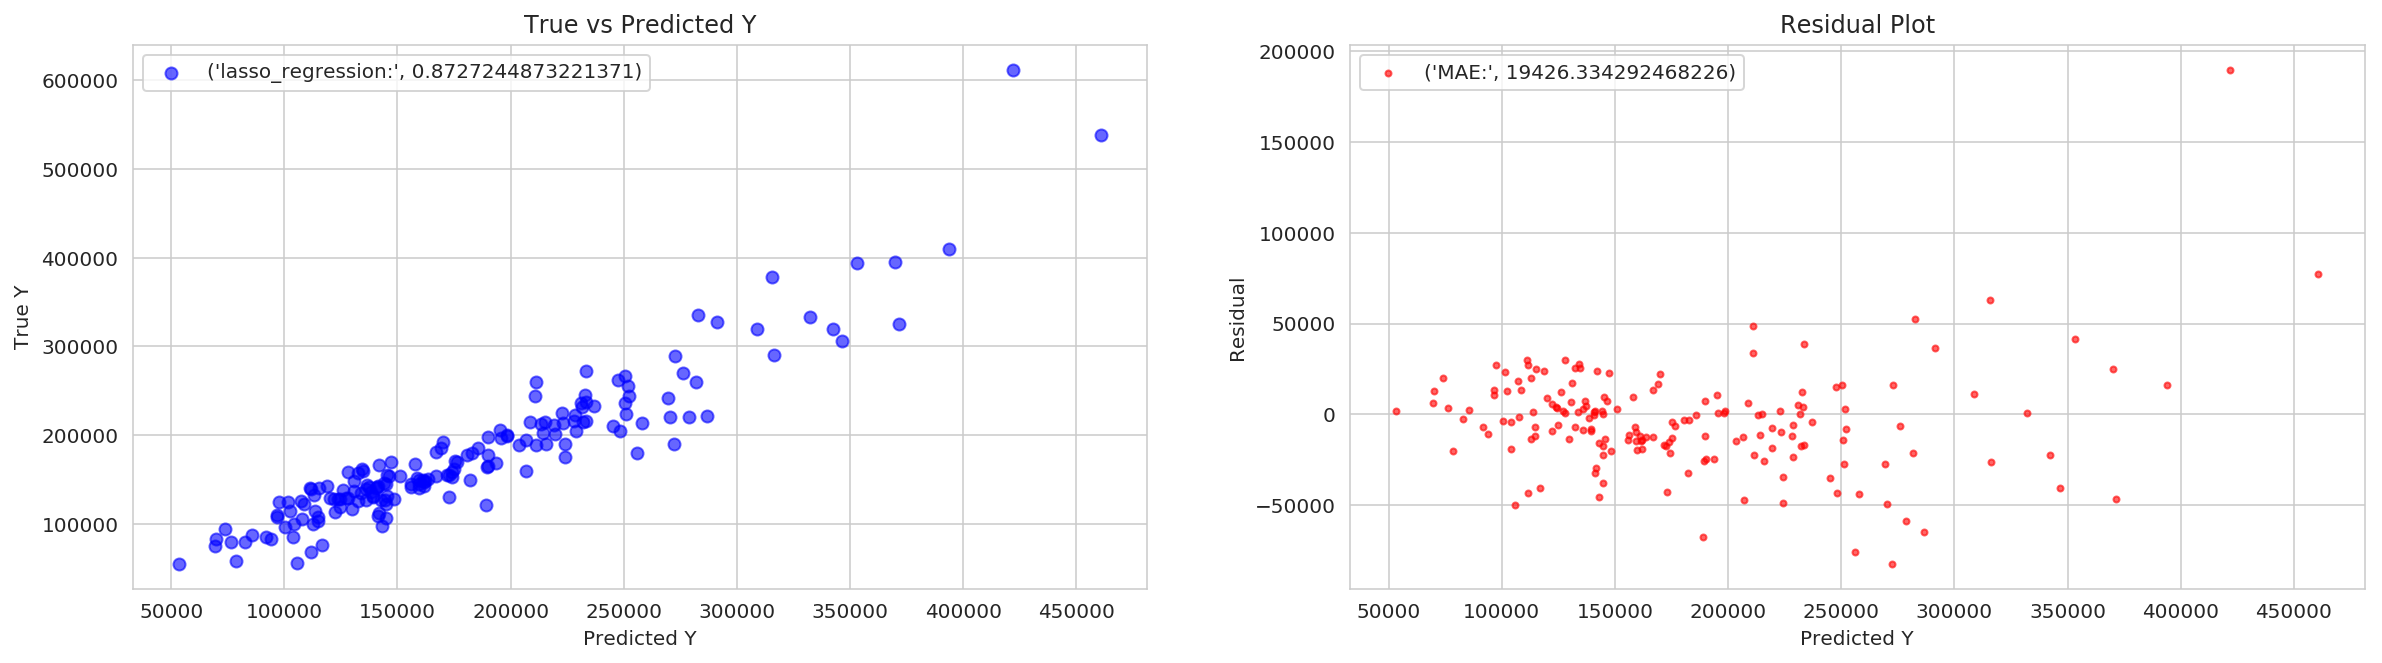

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Get the current axis out of the figure.
ax = fig.gca()
ax1 = axes[0]
ax2 = axes[1]

# Predicted vs Real y
ax1.scatter(lasso.predict(Xs_test), y_test, color='blue', alpha=0.6, label=("lasso_regression:", lasso.score(Xs_test, y_test)))
ax1.set_xlabel('Predicted Y')
ax1.set_ylabel('True Y')
ax1.legend(loc='best')
ax1.set_title('True vs Predicted Y')

ax2.scatter(lasso.predict(Xs_test), y_test-lasso.predict(Xs_test) ,color='red', marker='.', alpha=0.6, label=("MAE:", mean_absolute_error(y_test, lasso.predict(Xs_test))))
ax2.set_xlabel('Predicted Y')
ax2.set_ylabel('Residual')
ax2.legend(loc='best')
ax2.set_title('Residual Plot')


# Ridge Regression


In [35]:
ridge = RidgeCV(alphas=50.**np.linspace(0.1, 5, 10), fit_intercept=True, cv =10)

ridge.fit(Xs_train, y_train)

print("Ridge Regression score:", ridge.score(Xs_test, y_test))

Ridge Regression score: 0.8752237146267935


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [36]:
ridge_coefs = pd.DataFrame({'coef':ridge.coef_,
                            'mag':np.abs(ridge.coef_),
                            'variable':Xs_train.columns,})

ridge_coefs.sort_values('mag', inplace=True, ascending=False)

ridge_coefs.head(10)

,coef,mag,variable
12,13786.387737,13786.387737,GrLivArea
100,-13341.445534,13341.445534,BsmtQual_Gd
102,-11275.840535,11275.840535,BsmtQual_TA
59,10874.066927,10874.066927,Neighborhood_NridgHt
10,10285.678479,10285.678479,2ndFlrSF
22,8730.633665,8730.633665,GarageCars
58,8706.897799,8706.897799,Neighborhood_NoRidge
9,7237.203233,7237.203233,1stFlrSF
4,7172.651063,7172.651063,YearRemodAdd
65,6927.371140,6927.371140,Neighborhood_StoneBr


# Plotting True vs Predicted Y values and residual plot for Ridge


Text(0.5, 1.0, 'Residual Plot')

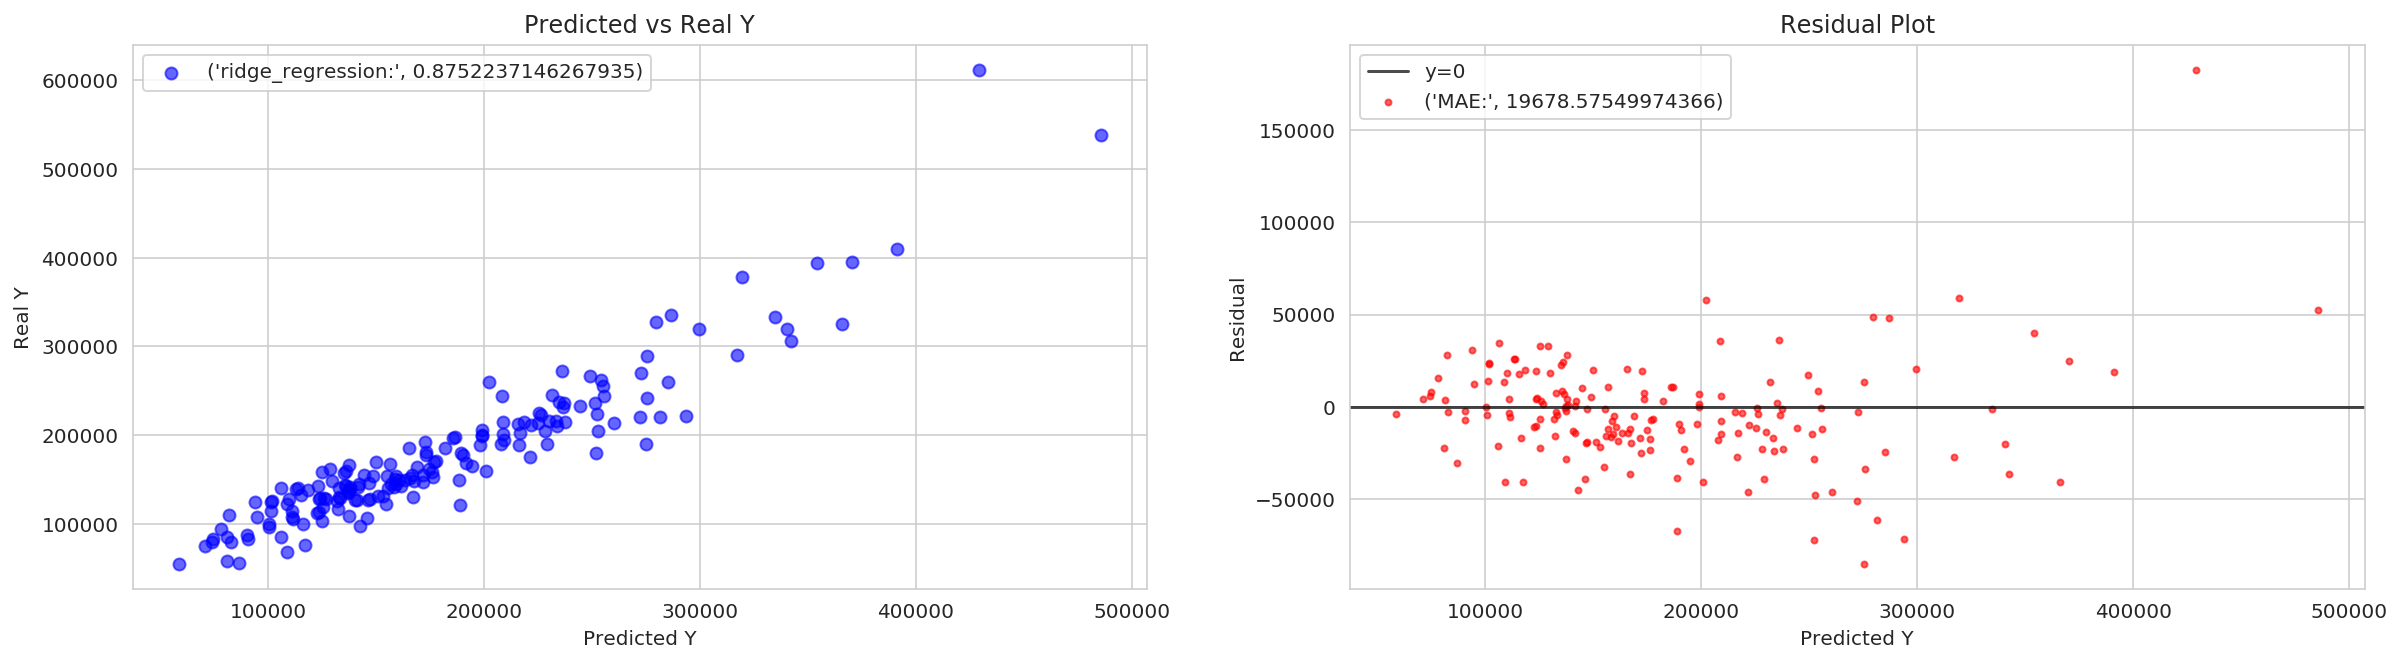

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Get the current axis out of the figure.
ax = fig.gca()
ax1 = axes[0]
ax2 = axes[1]


# Predicted vs Real y
ax1.scatter(ridge.predict(Xs_test), y_test, color='blue', alpha=0.6, label=("ridge_regression:", ridge.score(Xs_test, y_test)))
ax1.set_xlabel('Predicted Y')
ax1.set_ylabel('Real Y')
ax1.legend(loc='best')
ax1.set_title('Predicted vs Real Y')

ax2.scatter(ridge.predict(Xs_test), y_test-ridge.predict(Xs_test), color='red', marker='.', alpha=0.6,label=("MAE:", mean_absolute_error(y_test, ridge.predict(Xs_test))))
ax2.set_xlabel('Predicted Y')
ax2.set_ylabel('Residual')
ax2.axhline(y=0, color='black', alpha=0.7, label='y=0')
ax2.legend(loc='best')
ax2.set_title('Residual Plot')


# Stochastic Gradient Descent

In [39]:
sgd_parameters = {'alpha': np.linspace(0,1,5), 
                   'penalty': ['l1', 'l2'],
                   'loss': ['squared_loss','huber']}

sgd_reg = SGDRegressor(max_iter = 1000)
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_parameters, cv=5, verbose=False)

In [40]:
sgd_reg_gs.fit(Xs_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.  , 0.25, 0.5 , 0.75, 1.  ]), 'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [41]:
print(sgd_reg_gs.best_params_)
print(sgd_reg_gs.best_score_)
sgd_reg = sgd_reg_gs.best_estimator_

{'alpha': 0.25, 'loss': 'squared_loss', 'penalty': 'l2'}
0.7901970180715548


In [35]:
print("SGD Regression score:", sgd_reg_gs.score(Xs_test, y_test))


SGD Regression score: 0.8536356061913235


In [42]:
sgd_coefs = pd.DataFrame({'coef':sgd_reg.coef_,
                            'mag':np.abs(sgd_reg.coef_),
                            'variable':Xs_train.columns})
sgd_coefs.sort_values('mag', ascending=False, inplace=True)
sgd_coefs.head(10)

,coef,mag,variable
12,11533.685693,11533.685693,GrLivArea
59,10113.375997,10113.375997,Neighborhood_NridgHt
100,-8202.858515,8202.858515,BsmtQual_Gd
58,8073.809203,8073.809203,Neighborhood_NoRidge
9,7913.513347,7913.513347,1stFlrSF
22,7424.883576,7424.883576,GarageCars
10,6951.626557,6951.626557,2ndFlrSF
102,-6812.983230,6812.983230,BsmtQual_TA
8,6716.528737,6716.528737,TotalBsmtSF
4,6697.736059,6697.736059,YearRemodAdd


# Plotting True vs Predicted Y values and residual plot

Text(0.5, 1.0, 'Residual Plot')

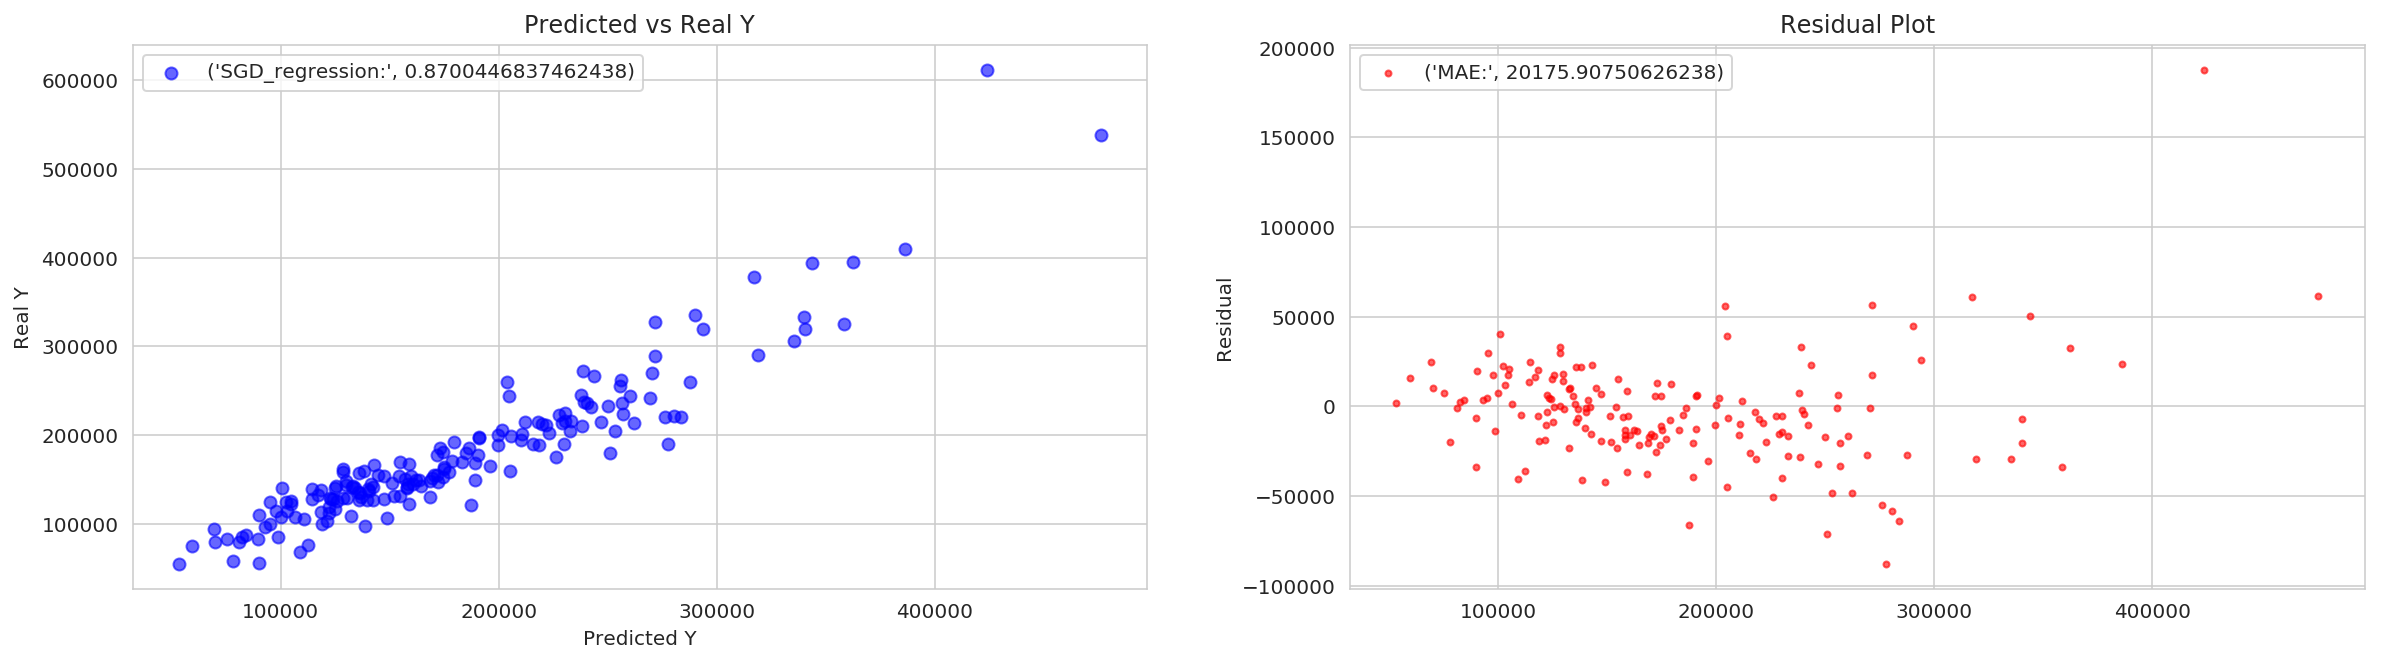

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Get the current axis out of the figure.
ax = fig.gca()
ax1 = axes[0]
ax2 = axes[1]

# Predicted vs Real y
ax1.scatter(sgd_reg_gs.predict(Xs_test), y_test, color='blue', alpha=0.6, label=("SGD_regression:", sgd_reg_gs.score(Xs_test, y_test)))
ax1.set_xlabel('Predicted Y')
ax1.set_ylabel('Real Y')
ax1.legend(loc='best')
ax1.set_title('Predicted vs Real Y')

ax2.scatter(sgd_reg_gs.predict(Xs_test), y_test-sgd_reg_gs.predict(Xs_test), color='red', marker='.', alpha=0.6,label=("MAE:", mean_absolute_error(y_test, sgd_reg_gs.predict(Xs_test))))
ax2.set_ylabel('Residual')
ax2.legend(loc='best')
ax2.set_title('Residual Plot')



In [44]:
fixed_features.SalePrice.values.mean()

180921.19589041095

Out of the 3 models, lasso regression seems to be the best model with r2 score of 0.87. and MAE at 19426.
It means the my model is 19426 off with the SalePrice, it is about 10% of the average SalePrice .
The best estimator for the sale price will be GrLivArea, BsmtQual_Gd, BsmtQual_Ta, Neighborhood_NridgHt, 
2ndFlrSF and GarageCars.

You can expect to command Higher Sale Price with the below features 
- the bigger the ground living area
- height of the basement(within 80-99 inches) typical and good
- within the neighbourhood of Northridge Heights
- larger the second floor area
- larger the garage in car capacity




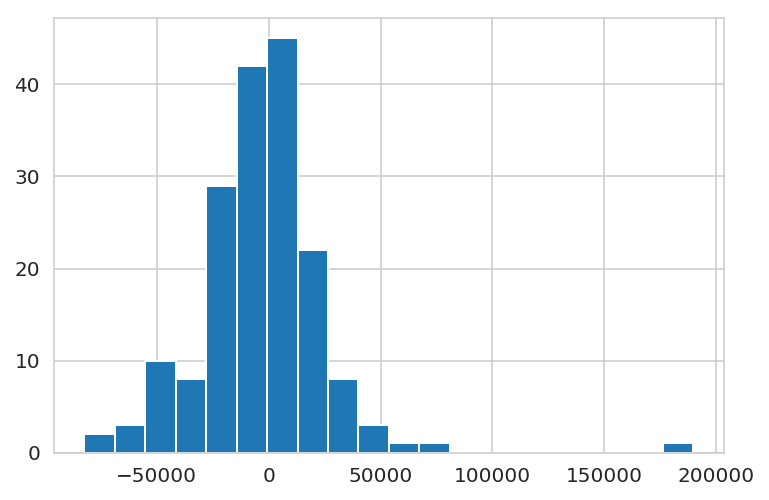

In [45]:
#Using Lasso result to plot the distribution of the residual
y_pred = lasso.predict(Xs_test)
#X_test['y_pred'] = y_pred
residual = y_test- y_pred
residual.hist(bins = 20)


Residual seems to be slightly skew to the right due to some outliers


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [46]:
#Defining the renovate-able feature and repeating the same process
non_fixed = house[['Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',\
          'MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtCond','BsmtExposure','BsmtFinType1',\
          'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',\
          'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF',\
          'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal']]


In [47]:
non_fixed_num = non_fixed.select_dtypes(include=np.number)
non_fixed_object = non_fixed.select_dtypes('O')

In [48]:
non_fixed_dummies = pd.get_dummies(non_fixed_object, drop_first= True)
non_fixed_features = non_fixed_num.merge(non_fixed_dummies, left_index = True, right_index = True,how = 'outer')

In [49]:
non_fixed_features.info()
#137 columns after adding dummy variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 136 entries, OverallQual to MiscFeature_TenC
dtypes: float64(1), int64(9), uint8(126)
memory usage: 293.8 KB


In [50]:
#Adding the fixed and renovate-able features and 
#perform another lasso regression to find out if the new features will improve performnce of the r2 score.
final_features = non_fixed_features + fixed_features
final_features = non_fixed_features.merge(fixed_features, left_index = True, right_index = True,how = 'outer')
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 246 entries, OverallQual to GarageType_NoGarage
dtypes: float64(2), int64(34), uint8(210)
memory usage: 710.1 KB


In [51]:
cols = list(final_features.columns)
cols.remove('SalePrice')

X = final_features[cols]
y = fixed_features.SalePrice


In [52]:
X_final_train= X[X['YrSold']<2010]
y_final_train= final_features.loc[final_features[final_features['YrSold']<2010].index, 'SalePrice']

X_final_test= X[X['YrSold']==2010]
y_final_test= final_features.loc[final_features[final_features['YrSold']==2010].index, 'SalePrice']


In [53]:
ss =StandardScaler()

Xs_final_train =pd.DataFrame(ss.fit_transform(X_final_train), columns=X.columns)
Xs_final_test =pd.DataFrame(ss.fit_transform(X_final_test), columns=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
#Using Lasso regression as it prove to be a better model among the 3 models and using the same parameters
best_lasso = LassoCV(n_alphas=100, cv=10)
best_lasso.fit(Xs_train, y_train)
print(best_lasso.get_params)
print(best_lasso.alpha_)

<bound method BaseEstimator.get_params of LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)>
601.7827750460926


In [56]:
final_lasso = Lasso(alpha = best_lasso.alpha_)

final_lasso.fit(Xs_final_train, y_final_train)

print("Lasso Regression score:", final_lasso.score(Xs_final_test, y_final_test))


Lasso Regression score: 0.8941422698389976


In [57]:
final_lasso_coefs = pd.DataFrame({'coef':final_lasso.coef_,
                            'mag':np.abs(final_lasso.coef_),
                            'variable':Xs_final_train.columns})

final_lasso_coefs.sort_values('mag', inplace=True, ascending=False)

final_lasso_coefs.head(10)

,coef,mag,variable
148,23587.151261,23587.151261,GrLivArea
0,14729.851946,14729.851946,OverallQual
126,-9835.659763,9835.659763,PoolQC_Gd
195,9082.762178,9082.762178,Neighborhood_NridgHt
8,8604.168284,8604.168284,PoolArea
236,-8522.738621,8522.738621,BsmtQual_Gd
139,8063.108283,8063.108283,YearBuilt
97,-7085.804114,7085.804114,KitchenQual_Gd
194,7044.946550,7044.946550,Neighborhood_NoRidge
238,-6863.582932,6863.582932,BsmtQual_TA


In [58]:
final_lasso_features = final_lasso_coefs.loc[final_lasso_coefs.mag != 0].info()
#107 predictor variables have been removed through lasso feature selection. 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 148 to 120
Data columns (total 3 columns):
coef        119 non-null float64
mag         119 non-null float64
variable    119 non-null object
dtypes: float64(2), object(1)
memory usage: 3.7+ KB


Text(0.5, 1.0, 'Residual Plot')

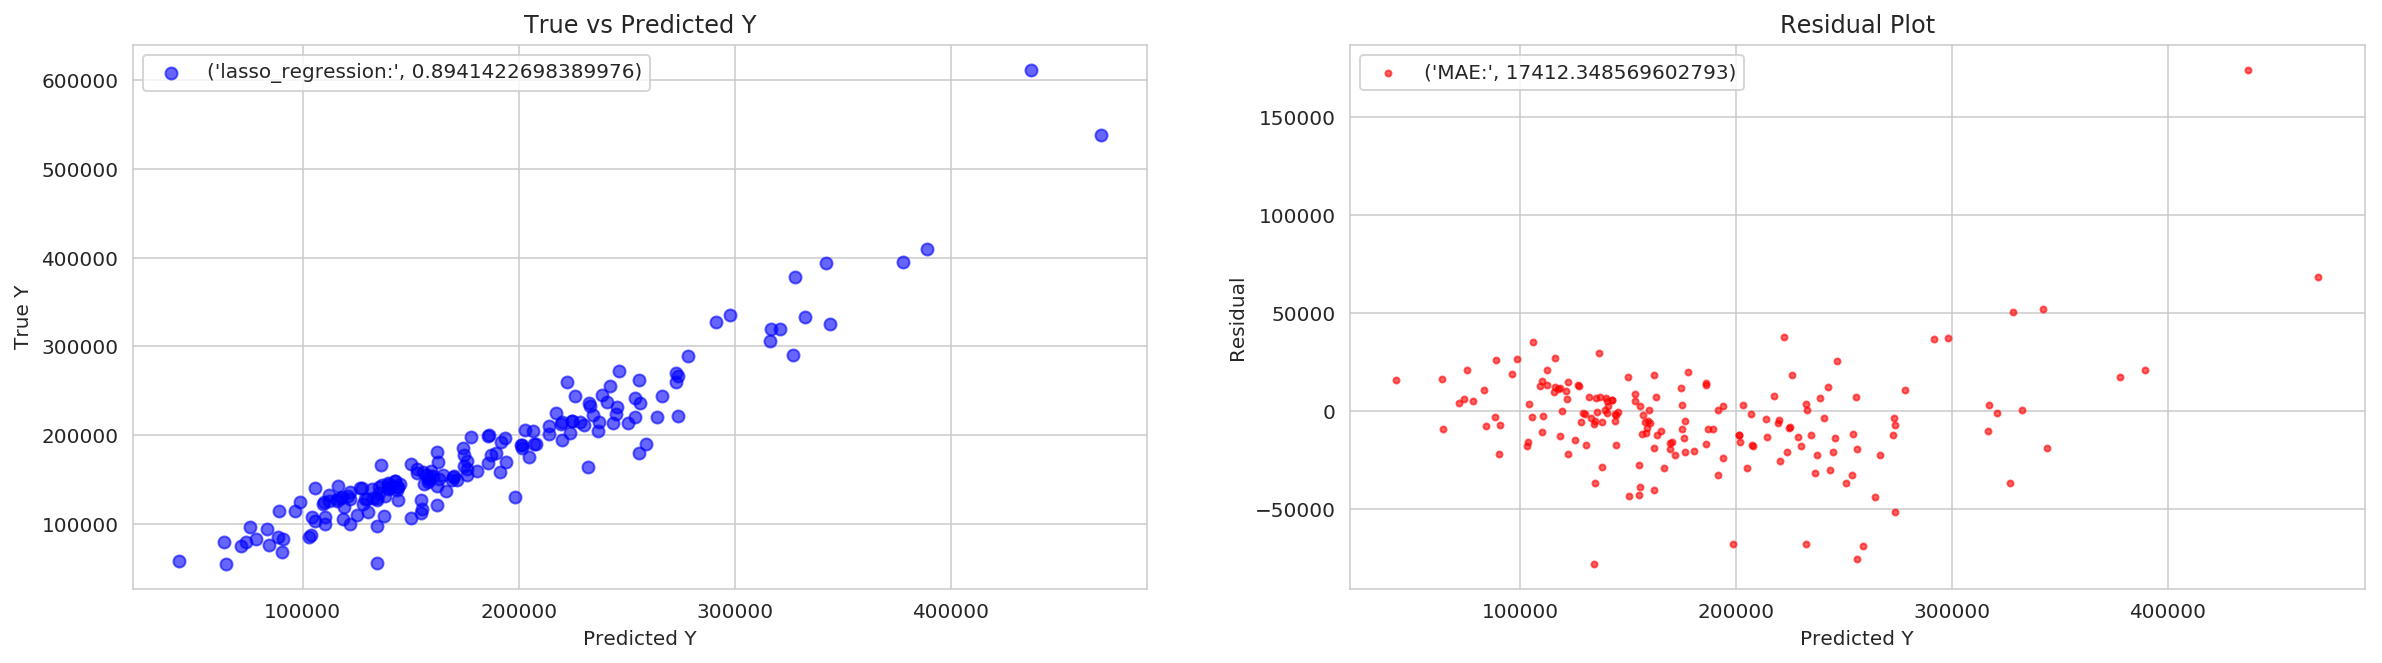

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Get the current axis out of the figure.
ax = fig.gca()
ax1 = axes[0]
ax2 = axes[1]

# Predicted vs Real y
ax1.scatter(final_lasso.predict(Xs_final_test), y_final_test, color='blue', alpha=0.6, label=("lasso_regression:", final_lasso.score(Xs_final_test, y_final_test)))
ax1.set_xlabel('Predicted Y')
ax1.set_ylabel('True Y')
ax1.legend(loc='best')
ax1.set_title('True vs Predicted Y')

ax2.scatter(final_lasso.predict(Xs_final_test), y_final_test - final_lasso.predict(Xs_final_test) ,color='red', marker='.', alpha=0.6, label=("MAE:", mean_absolute_error(y_final_test, final_lasso.predict(Xs_final_test))))
ax2.set_xlabel('Predicted Y')
ax2.set_ylabel('Residual')
ax2.legend(loc='best')
ax2.set_title('Residual Plot')

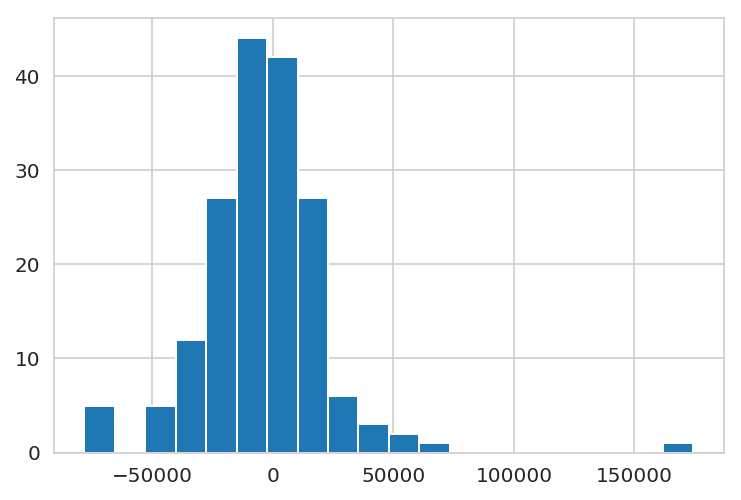

In [60]:
y_final_pred = final_lasso.predict(Xs_final_test)

new_residual = y_test - y_final_pred
new_residual.hist(bins = 20)



# By adding the renovate-able features, the mean absolute error has improved from 19426 to 17412 and r2 score has improved from 0.872 to 0.894. From the Observation on the top 10 highest weighted features, pool quality and pool area seems to be a crucial renovate-able features that the company should consider for better appreciation in the sale price.